In [1]:
import numpy as np
import pandas as pd
import os
import pandas as pd
import sys

# Config

In [2]:
HYPER_OPT = False 
HYPER_OPT_TIME = 3600*5
USE_ORIGINAL_DATA = False 
SUBMIT_TO_KAGGLE = False
AUTOGLUON_TIME = 3600*11
RETRAIN = True
USE_NONLOG = True
STACK_LEVELS = 4

In [3]:
from pathlib import Path
from datetime import datetime
import sys

# Define the base directory
base_dir = Path.cwd().resolve().parents[1]

# Define subdirectories
data_dir = base_dir / "data"
model_dir = base_dir / "models"
notebooks_dir = base_dir / "notebooks"

# Create a timestamped directory for AutoGluon
autogluon_folder = "AutogluonModels" / f"ag-{datetime.now():%Y%m%d_%H%M%S}"

# Append base_dir to sys.path
sys.path.append(str(base_dir))

# Data Extraction

In [4]:
from axyom_utilities.data_extraction import extract_data
from axyom_utilities.training import train_model_cv
from axyom_utilities.preprocessing import * 
from toolz import pipe
import joblib

In [5]:
X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, USE_ORIGINAL_DATA, log_transform=True)
y_train_nonlog = np.expm1(y_train)

if USE_NONLOG:
    nonlog_oof_preds, nonlog_test_preds = joblib.load('nonlog_feature/cat_non_loged.pkl')
    
    X_train["nonlog"] = nonlog_oof_preds
    X_test["nonlog"] = nonlog_test_preds

# Data Cleaning

In [6]:
from axyom_utilities.preprocessing import freq_encode, preprocess_dates, clean_categorical, frequency_encode
from toolz import pipe

def feature_engineering(df):
    
    # df = freq_encode(df)
    
    df['MissingHealth'] = df['Health Score'].isna().astype(int)
    df['Claims v Duration'] = (df['Previous Claims'] / df['Insurance Duration']).replace([np.inf, -np.inf], np.nan)
    df['Health vs Claims'] = (df['Health Score'] / df['Previous Claims']).replace([np.inf, -np.inf], np.nan)
    
    def duplicate_int(col, df):
        df[col + ' Integer'] = df[col].apply(lambda x: int(x) if pd.notna(x) else x)
        #df[col] = df[col].fillna('None').astype('category')
        
        return df
    
    df = duplicate_int('Health Score', df)
    df = duplicate_int('Credit Score', df)
    df = duplicate_int('Previous Claims', df)
    df = duplicate_int('Annual Income', df)
    
    df['MissingValuesCount'] = df.isna().sum(axis=1)
    
    # df = freq_encode(df, 'Customer Feedback')
    # df = freq_encode(df, 'Marital Status')
    
    return df

preprocessor = lambda df: pipe(df,\
    preprocess_dates,
    clean_categorical,
    feature_engineering,  
)

X_train = preprocessor(X_train)
X_test = preprocessor(X_test)
if USE_ORIGINAL_DATA:
    X_orig = preprocessor(X_orig)
    
frequency_encode(X_train, X_test, drop_org=False) # data leaking but acceptable in this context


(          Age  Gender  Annual Income Marital Status  Number of Dependents  \
 id                                                                          
 0        19.0  Female        10049.0        Married                   1.0   
 1        39.0  Female        31678.0       Divorced                   3.0   
 2        23.0    Male        25602.0       Divorced                   3.0   
 3        21.0    Male       141855.0        Married                   2.0   
 4        21.0    Male        39651.0         Single                   1.0   
 ...       ...     ...            ...            ...                   ...   
 1199995  36.0  Female        27316.0        Married                   0.0   
 1199996  54.0    Male        35786.0       Divorced                   NaN   
 1199997  19.0    Male        51884.0       Divorced                   0.0   
 1199998  55.0    Male            NaN         Single                   1.0   
 1199999  21.0  Female            NaN       Divorced            

In [7]:
X_train["Premium Amount"] = y_train # for autogluon

# Model Training

In [8]:
from autogluon.tabular import TabularDataset, TabularPredictor
from datetime import datetime


predictor = TabularPredictor(
    problem_type='regression',
    eval_metric='rmse',
    label="Premium Amount",
    #groups='fold',
    verbosity=2,
    path=autogluon_folder
)

predictor.fit(
    train_data=X_train,
    time_limit=AUTOGLUON_TIME,
    presets='best_quality',
    excluded_model_types=['KNN', 'NN_TORCH', 'FASTAI', 'RF'],
    ag_args_fit={'num_gpus': 1},
    num_stack_levels=STACK_LEVELS
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       9.71 GB / 15.82 GB (61.4%)
Disk Space Avail:   168.61 GB / 930.65 GB (18.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=4, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up t

In [9]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L6,-1.030434,root_mean_squared_error,2237.366250,28226.566739,0.021153,9.774155,6,True,127
1,WeightedEnsemble_L3,-1.030443,root_mean_squared_error,1407.737926,13595.255639,0.022356,6.433581,3,True,58
2,WeightedEnsemble_L4,-1.030482,root_mean_squared_error,2001.695278,22510.337692,0.020804,5.726132,4,True,87
3,WeightedEnsemble_L5,-1.030522,root_mean_squared_error,2327.735936,30095.153929,0.020708,4.999675,5,True,112
4,LightGBM_r131_BAG_L2,-1.030540,root_mean_squared_error,1281.841604,10500.674143,18.190284,252.872691,2,True,34
5,LightGBMXT_BAG_L3,-1.030547,root_mean_squared_error,1870.566595,19616.422019,4.003489,90.664383,3,True,59
6,LightGBM_r96_BAG_L3,-1.030554,root_mean_squared_error,1883.638436,19745.959738,17.075329,220.202102,3,True,68
7,LightGBM_r15_BAG_L2,-1.030557,root_mean_squared_error,1273.227075,10401.826008,9.575755,154.024556,2,True,53
8,LightGBM_r15_BAG_L3,-1.030557,root_mean_squared_error,1874.432946,19662.299456,7.869839,136.541820,3,True,85
9,CatBoost_BAG_L3,-1.030561,root_mean_squared_error,1866.925628,19779.860429,0.362522,254.102793,3,True,61


In [10]:
leaderboard = predictor.leaderboard(silent=True)

In [11]:
predictor.plot_ensemble_model()

'C:\\Users\\Axyom\\Kaggle\\PG S4e12 - Regression Insurance\\AutogluonModels\\ag-20241225_165244\\ensemble_model.png'

In [12]:
best_model_name = predictor.model_best

In [13]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

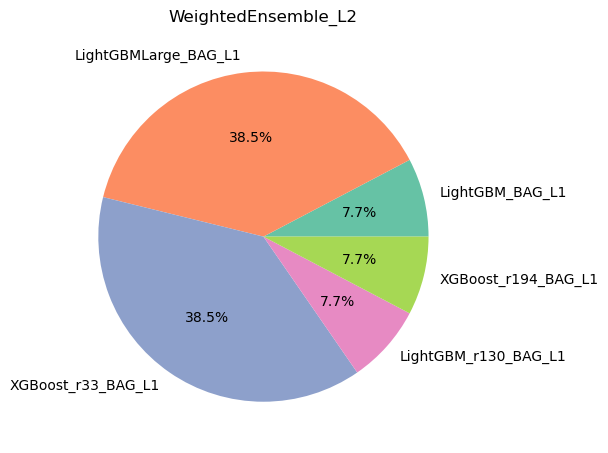

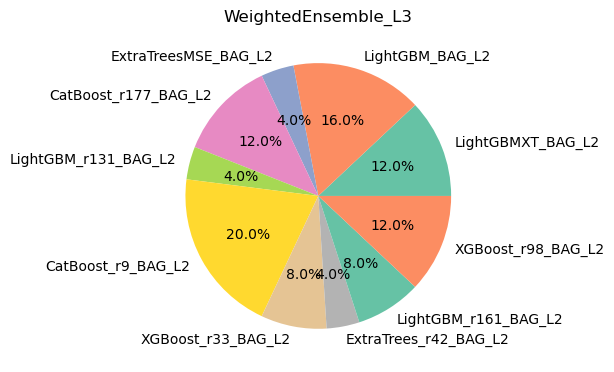

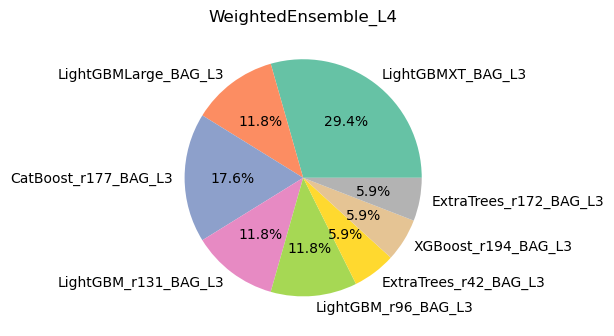

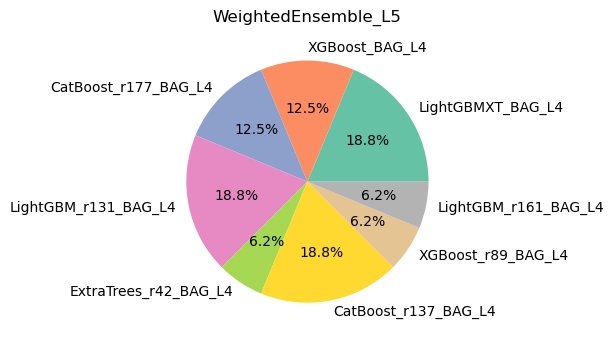

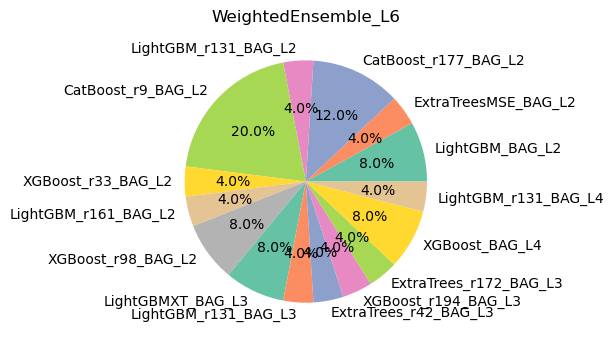

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [15]:
best_model_score = -leaderboard[leaderboard['model'] == best_model_name]['score_val'].values[0]
print(f"Best Model: {best_model_name}")
print(f"Validation Score: {best_model_score}")

Best Model: WeightedEnsemble_L6
Validation Score: 1.0304339590646459


In [16]:
test_preds = predictor.predict(X_test)
oof_preds = predictor.predict_oof()

In [17]:
import json
from pathlib import Path

# Save OOF predictions as a CSV file
oof_preds_df = pd.DataFrame({"oof_preds": oof_preds})
oof_preds_df.to_csv(autogluon_folder/"oof_preds.csv", index=False)

test_preds_df = pd.DataFrame({"test_preds": test_preds})
test_preds_df.to_csv(autogluon_folder/"test_preds.csv", index=False)

# with open(autogluon_folder/"best_params", "w") as f:
#     json.dump(best_params, f, indent=4)

#joblib.dump(results["models"], "models.pkl")

In [18]:
# # Save OOF predictions as a CSV file
# oof_preds_df = pd.DataFrame({"oof_preds": oof_preds})
# oof_preds_df.to_csv("oof_preds", index=False)
# print("OOF predictions saved to oof_preds.csv.")

# test_preds_df = pd.DataFrame({"test_preds": test_preds})
# test_preds_df.to_csv("test_preds", index=False)
# print("Test predictions saved to test_preds.csv.")

# Submission

In [19]:
y_pred = np.maximum(0, np.expm1(test_preds))

submission = pd.DataFrame({
    'id': X_test.index,  
    'Premium Amount': y_pred
})

FILE_PATH = autogluon_folder/f"Autogluon_v2_{best_model_score:.4f}.csv"

submission.to_csv(FILE_PATH, index=False)

In [20]:
import os

if False: 

    # Define your message and file paths
    COMP_NAME = "playground-series-s4e12"

    SUBMIT_MESSAGE = f"Clean AutoGluon: Mean score: {best_model_score:.4f}"

    # Submit to Kaggle
    os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')